`Дисциплина: Методы и технологии машинного обучения`   
`Уровень подготовки: бакалавриат`   
`Направление подготовки: 01.03.02 Прикладная математика и информатика`   
`Семестр: осень 2021/2022`   




# Упражнение №3: Методы снижения размерности. Регуляризация логистической регрессии. 



Точность всех моделей оценивается методом перекрёстной проверки по 10 блокам.  

*Модели*: множественная линейная регрессия 


# Указания к выполнению


## Загружаем пакеты

In [2]:
# загрузка пакетов: инструменты --------------------------------------------
#  работа с массивами
import numpy as np
#  фреймы данных
import pandas as pd
#  распределение Стьюдента для проверки значимости
from scipy.stats import t
# подсчёт частот внутри массива
from collections import Counter
#  графики
import matplotlib as mpl
#  стили и шаблоны графиков на основе matplotlib
import seaborn as sns

# загрузка пакетов: данные -------------------------------------------------
from sklearn import datasets

# загрузка пакетов: модели -------------------------------------------------
#  стандартизация показателей
from sklearn.preprocessing import StandardScaler
#  метод главных компонент
from sklearn.decomposition import PCA
# метод частных наименьших квадратов
from sklearn.cross_decomposition import PLSRegression
#  логистическая регрессия (ММП)
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
#  перекрёстная проверка по k блокам
from sklearn.model_selection import KFold, cross_val_score
#  расчёт Acc и сводка по точности классификации
from sklearn.metrics import accuracy_score, classification_report

In [3]:
# константы
#  ядро для генератора случайных чисел
my_seed = 20
#  создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
#  примеры стилей и шаблонов графиков: 
#  http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
mpl.style.use('seaborn-whitegrid')
sns.set_palette("Set2")
# раскомментируйте следующую строку, чтобы посмотреть палитру
# sns.color_palette("Set2")

In [4]:
# функция, которая строит график сжатия коэффициентов в ридж и лассо
#  из репозитория к книге С.Рашки Python и машинное обучение,
#  слегка переработанная
def plot_coeffs_traces (X, y, class_number, penalty_name, C_opt, col_names,
                        C_min_pow=-4, C_max_pow=3.) :
    fig = plt.figure()
    ax = plt.subplot(111)    
    
    # палитра
    colors = sns.color_palette("Spectral", len(col_names)-1)
    
    weights, params = [], []
    for c in np.arange(C_min_pow, C_max_pow+1):
        lr = LogisticRegression(penalty=penalty_name, 
                                C=10.**c, solver='liblinear', 
                                multi_class='ovr', random_state=my_seed)
        lr.fit(X, y)
        weights.append(lr.coef_[class_number])
        params.append(10**c)

    weights = np.array(weights)

    for column, color in zip(range(weights.shape[1]), colors):
        plt.plot(params, weights[:, column],
                 label=col_names[column],
                 color=color)

    # отсечки по оптимальным C
    plt.axvline(x=C_opt[class_number], color='magenta', 
                linestyle='--', linewidth=1)

    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.xlim([10**(C_min_pow), 10**C_max_pow])
    plt.ylabel('weight coefficient')
    plt.xlabel('C')
    plt.xscale('log')
    plt.legend(loc='upper left')
    ax.legend(loc='upper center', 
              bbox_to_anchor=(1.38, 1.03),
              ncol=1, fancybox=True)
    plt.show()

## If you choose to work in Colab,

1. Visit [Drive folder](https://drive.google.com/drive/folders/1E9_u-v8chGmPwgROBEorD9hT609ysv_W?usp=sharing).

2. Right click on folder name -> "Add a shortcut to Drive" -> select "My Drive" -> "Add shortcut".

In [52]:
# Detect if we are in Google Colaboratory
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

from pathlib import Path
# Determine the locations of auxiliary libraries and datasets.
# AUX_DATA_ROOT is where 'notmnist.py', 'animation.py' and 'tiny-imagenet-2020.zip' are.
if IN_COLAB:
    google.colab.drive.mount("/content/drive")
    
    # Change this if you created the shortcut in a different location
    AUX_DATA_ROOT = Path("/content/drive/My Drive/data")
    
    assert AUX_DATA_ROOT.is_dir(), "Have you forgot to 'Add a shortcut to Drive'?"
    
    import sys
    sys.path.insert(0, str(AUX_DATA_ROOT))
else:
    AUX_DATA_ROOT = Path(".")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
# загружаем таблицу и превращаем её во фрейм
import os 

DF_all = pd.read_csv(os.path.join(AUX_DATA_ROOT, 'default_of_credit_card_clients.csv'))

# выясняем размерность фрейма
print('Число строк и столбцов в наборе данных:\n', DF_all.shape)

Число строк и столбцов в наборе данных:
 (30000, 24)


In [54]:
# удаляем ненужные объясняющие переменные
DF_all = DF_all.drop('PAY_3', 1)
DF_all = DF_all.drop('PAY_4', 1)
DF_all = DF_all.drop('PAY_5', 1)
DF_all = DF_all.drop('PAY_6', 1)
DF_all = DF_all.drop('BILL_AMT3', 1)
DF_all = DF_all.drop('BILL_AMT4', 1)
DF_all = DF_all.drop('BILL_AMT5', 1)
DF_all = DF_all.drop('BILL_AMT6', 1)

In [55]:
# выясняем размерность фрейма
print('Число строк и столбцов в наборе данных:\n', DF_all.shape)

Число строк и столбцов в наборе данных:
 (30000, 16)


In [56]:
DF_all.head (5)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,BILL_AMT1,BILL_AMT2,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y
0,20000,2,2,1,24,2,2,3913,3102,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,2682,1725,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,29239,14027,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,46990,48233,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,8617,5670,2000,36681,10000,9000,689,679,0


Отложим 15% наблюдений для прогноза (теста).  

In [57]:
# наблюдения для моделирования
DF = DF_all.sample(frac=0.85, random_state=my_seed)
# отложенные наблюдения
DF_predict = DF_all.drop(DF.index)

In [58]:
# типы столбцов фрейма
DF.dtypes

LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
AGE          int64
PAY_0        int64
PAY_2        int64
BILL_AMT1    int64
BILL_AMT2    int64
PAY_AMT1     int64
PAY_AMT2     int64
PAY_AMT3     int64
PAY_AMT4     int64
PAY_AMT5     int64
PAY_AMT6     int64
Y            int64
dtype: object

Проверим, нет ли в таблице пропусков.  

In [13]:
# считаем пропуски в каждом столбце
DF.isna().sum()

LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
BILL_AMT1    0
BILL_AMT2    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
Y            0
dtype: int64

Пропусков не обнаружено.  

# Предварительный анализ данных  

## Описательные статистики  

Считаем доли классов целевой переменной `Y`.  

In [14]:
# метки классов
DF.Y.unique()

array([0, 1])

In [15]:
# доли классов
np.around(DF.Y.value_counts() / len(DF.index), 3)

0    0.779
1    0.221
Name: Y, dtype: float64

Всего 2 целевых класса, их доли сильно различаются

Все объясняющие переменные набора данных непрерывные, кроме SEX, EDUCATION и MARRIAGE. Рассчитаем для них описательные статистики.  

In [20]:
DF.drop(['SEX', 'EDUCATION', 'MARRIAGE'], axis=1).describe()

,LIMIT_BAL,AGE,PAY_0,PAY_2,BILL_AMT1,BILL_AMT2,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y
count,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,2.550000e+04,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000
mean,168077.242353,35.486471,-0.015608,-0.131882,51399.370471,49355.392471,5699.709020,5.963576e+03,5221.213333,4820.416824,4850.173843,5255.832627,0.220588
std,129837.678356,9.213824,1.126387,1.201093,73891.950872,71405.114321,16687.930104,2.327991e+04,16875.401546,15353.273877,15584.945606,17773.623966,0.414651
min,10000.000000,21.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,28.000000,-1.000000,-1.000000,3538.500000,2983.000000,1000.000000,8.500000e+02,390.000000,298.000000,265.000000,133.000000,0.000000
50%,140000.000000,34.000000,0.000000,0.000000,22407.000000,21241.500000,2103.000000,2.010000e+03,1800.000000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,41.000000,0.000000,0.000000,67255.750000,64150.000000,5019.000000,5.000000e+03,4523.250000,4030.750000,4078.000000,4045.250000,0.000000
max,800000.000000,79.000000,8.000000,8.000000,653062.000000,743970.000000,873552.000000,1.684259e+06,889043.000000,621000.000000,426529.000000,528666.000000,1.000000


Выводы по описательным статистикам: есть отрицательные значения объясняющих переменных, масштабы измерения отличаются. Для работы с методами снижения размерности и регуляризации понадобится стандартизация значений. 

Для категориальных переменных SEX, EDUCATION и MARRIAGE подсчитаем частоты значений


In [23]:
count_sex = DF['SEX'].value_counts()
pd.DataFrame(count_sex)

,SEX
2,15408
1,10092


In [24]:
count_edu = DF['EDUCATION'].value_counts()
pd.DataFrame(count_edu)

,EDUCATION
2,11894
1,9055
3,4141
5,253
4,100
6,46
0,11


In [25]:
count_mar = DF['MARRIAGE'].value_counts()
pd.DataFrame(count_mar)

,MARRIAGE
2,13585
1,11605
3,261
0,49


  

## Визуализация разброса переменных внутри классов  

Поскольку в наборе данных 15 объясняющих переменных, и все они непрерывные, анализ матричного графика разброса будет затруднительным. Построим коробчатые диаграммы для объясняющих переменных, чтобы сравнить средние уровни и разброс по классам.  

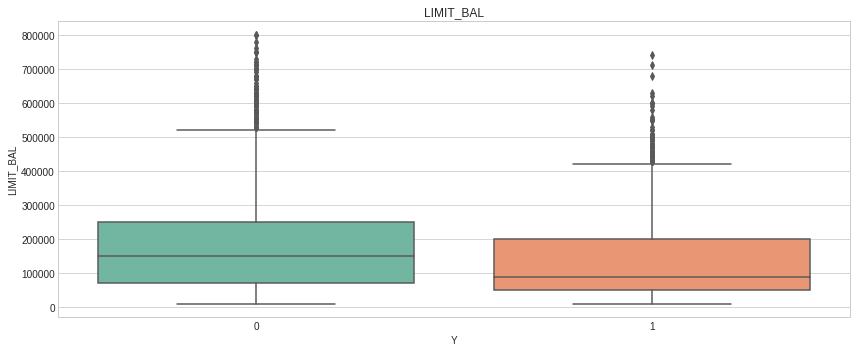

In [34]:
# создаём полотно и делим его на четыре части
fig = plt.figure(figsize=(12, 5))
gs = mpl.gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0, 0])


axs = [ax1]

cols_loop = list(DF.columns[:1].values)
for col_name in cols_loop :
    i = cols_loop.index(col_name)
    sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
    axs[i].set_ylabel(col_name)
    axs[i].set_title(col_name)

# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

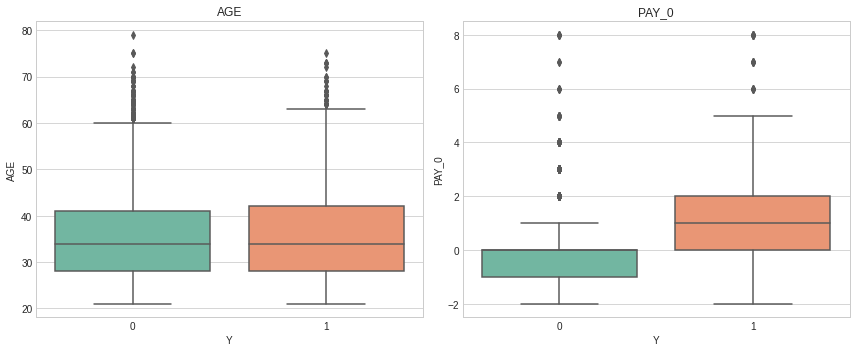

In [35]:
fig = plt.figure(figsize=(12, 5))
gs = mpl.gridspec.GridSpec(1, 2)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])



axs = [ax1, ax2]

cols_loop = list(DF.columns[4:6].values)
for col_name in cols_loop :
    i = cols_loop.index(col_name)
    sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
    axs[i].set_ylabel(col_name)
    axs[i].set_title(col_name)

# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

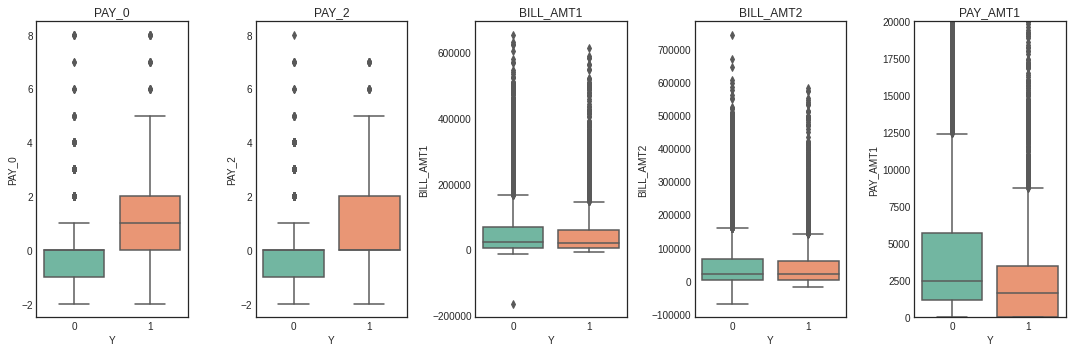

In [ ]:
# создаём полотно и делим его на четыре части
fig = plt.figure(figsize=(15, 5))
gs = mpl.gridspec.GridSpec(1, 5)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
ax5 = plt.subplot(gs[0, 4])

axs = [ax1, ax2, ax3, ax4, ax5]

cols_loop = list(DF.columns[5:10].values)
for col_name in cols_loop :
    i = cols_loop.index(col_name)
    sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
    axs[i].set_ylabel(col_name)
    axs[i].set_title(col_name)

plt.ylim(0, 20000)
# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

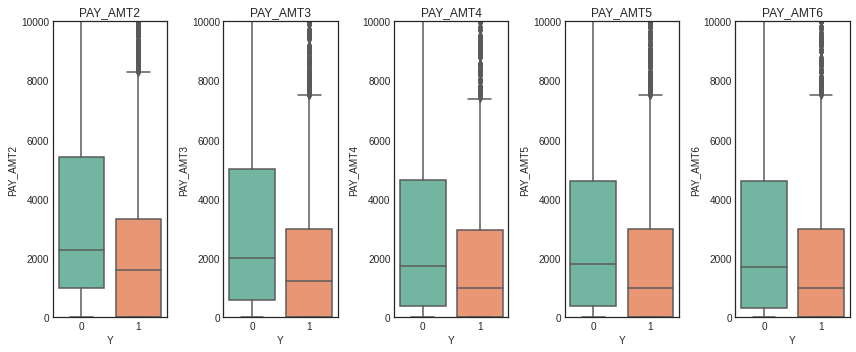

In [ ]:
# создаём полотно и делим его на четыре части
fig = plt.figure(figsize=(12, 5))
gs = mpl.gridspec.GridSpec(1, 5)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
ax5 = plt.subplot(gs[0, 4])
axs = [ax1, ax2, ax3, ax4, ax5]

cols_loop = list(DF.columns[10:15].values)
for col_name in cols_loop :
    i = cols_loop.index(col_name)
    sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
    axs[i].set_ylabel(col_name)
    axs[i].set_title(col_name)
    axs[i].set_ylim(0, 10000)

# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

Меньше всего различаются коробчатые диаграммы по переменным `AGE`. Но классы по зависимой переменной `Y` неплохо разделяются по всем остальным объясняющим переменным.  

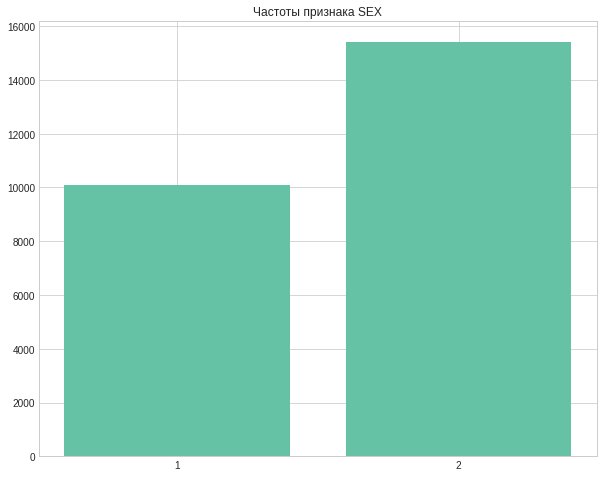

In [36]:
plt.figure(figsize=(10,8))
plt.bar(count_sex.index, count_sex);
plt.title("Частоты признака SEX")
plt.xticks([1,2]);

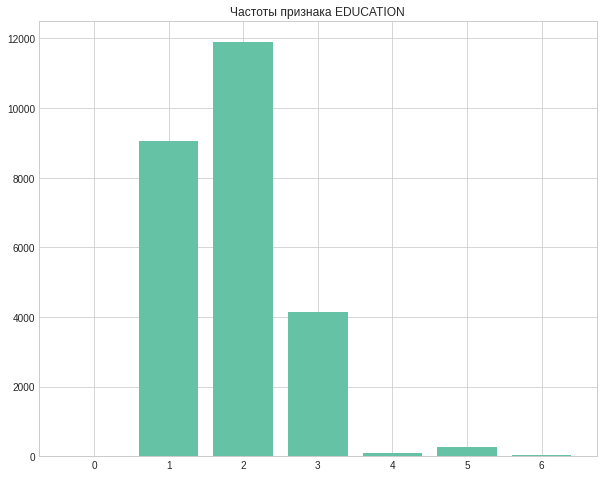

In [38]:
plt.figure(figsize=(10,8))
plt.bar(count_edu.index, count_edu)
plt.title("Частоты признака EDUCATION");

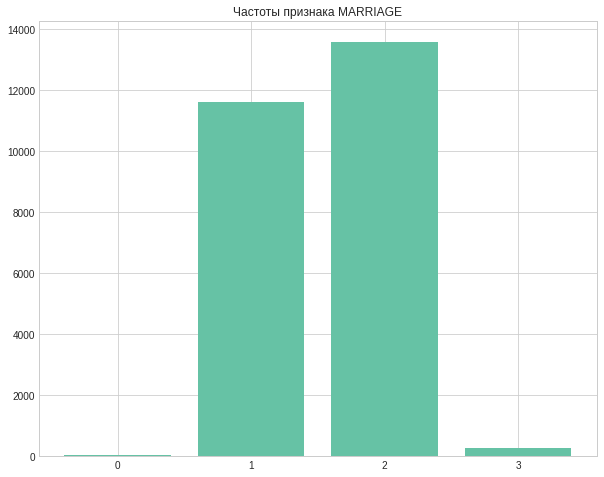

In [40]:
plt.figure(figsize=(10,8))
plt.bar(count_mar.index, count_mar)
plt.title("Частоты признака MARRIAGE")
plt.xticks([0,1,2,3]);

Теперь перекодируем категориальные переменные SEX, EDUCATION и MARRIAGE с помощью OneHotEncoder

In [59]:
from sklearn.preprocessing import OneHotEncoder

nom_col_names=['SEX', 'EDUCATION', 'MARRIAGE']

one_hot=OneHotEncoder()

recoded=one_hot.fit_transform(DF[nom_col_names]).toarray()
clmns=one_hot.get_feature_names(nom_col_names)
df_dummy_nom=pd.DataFrame(recoded, columns=clmns)

print(df_dummy_nom.shape)
df_dummy_nom.head()

(25500, 13)


,SEX_1,SEX_2,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Сконкатенируем наши датафреймы и удалим ненужные столбцы

In [63]:
DF_num = pd.concat([DF.loc[:,DF.dtypes=='int64'].reset_index(),df_dummy_nom], axis=1)
DF_num = DF_num.drop(['SEX', 'EDUCATION', 'MARRIAGE', 'index'], axis=1)
print('Размерность обучающего фрейма после перекодировки:', DF_num.shape)

print()
DF_num.head()

Размерность обучающего фрейма после перекодировки: (25500, 26)



,LIMIT_BAL,AGE,PAY_0,PAY_2,BILL_AMT1,BILL_AMT2,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y,SEX_1,SEX_2,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
0,60000,28,1,2,47262,46226,0,2100,2000,2000,2000,3000,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,30000,34,2,-1,99568,32326,33000,33000,5810,1325,0,3095,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,50000,30,0,0,45948,50813,6012,10,8212,1200,4008,4407,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,240000,42,2,2,259511,258208,11000,0,12300,14288,0,6887,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,300000,28,0,0,275855,286812,15000,7000,50000,12000,0,13000,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Теперь сделаем то же самое на отложенных данных DF_predict

In [64]:
nom_col_names=['SEX', 'EDUCATION', 'MARRIAGE']

recoded = one_hot.fit_transform(DF_predict[nom_col_names]).toarray()
clmns = one_hot.get_feature_names(nom_col_names)
df_dummy_nom = pd.DataFrame(recoded, columns=clmns)

print(df_dummy_nom.shape)
df_dummy_nom.head()

(4500, 13)


,SEX_1,SEX_2,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Соединим и удалим ненужное

In [65]:
DF_predict = pd.concat([DF_predict.loc[:, DF_predict.dtypes=='int64'].reset_index(), df_dummy_nom], axis=1)
DF_predict = DF_predict.drop(['SEX', 'EDUCATION', 'MARRIAGE', 'index'], axis=1)
print('Размерность тестового фрейма после перекодировки:', DF_predict.shape)

print()
DF_predict.head()

Размерность тестового фрейма после перекодировки: (4500, 26)



,LIMIT_BAL,AGE,PAY_0,PAY_2,BILL_AMT1,BILL_AMT2,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y,SEX_1,SEX_2,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
0,90000,34,0,0,29239,14027,1518,1500,1000,1000,1000,5000,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,50000,57,-1,0,8617,5670,2000,36681,10000,9000,689,679,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,140000,28,0,0,11285,14096,3329,0,432,1000,1000,1000,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,50000,23,1,2,50614,29173,0,1500,1100,1200,1300,1100,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,320000,49,0,0,253286,246536,10358,10000,75940,20000,195599,50000,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Корреляционный анализ   

Теперь посмотрим на взаимодействие объясняющих переменных.  

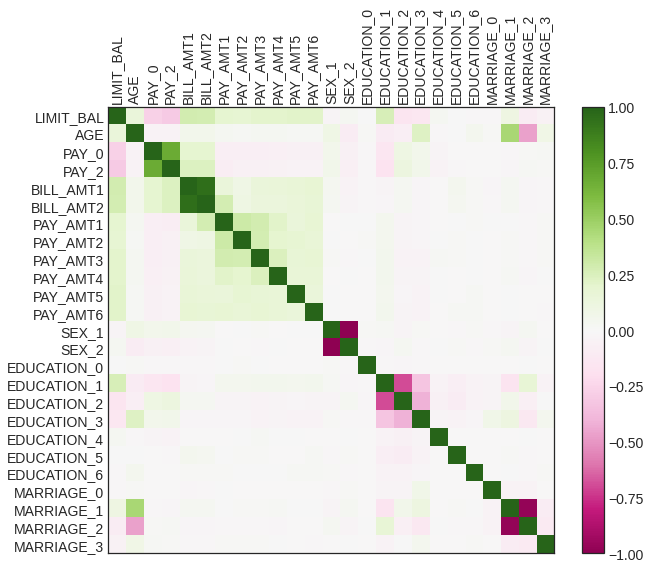

In [66]:
# рассчитываем корреляционную матрицу
corr_mat = DF_num.drop('Y', axis=1).corr()
col_names = DF_num.drop('Y', axis=1).columns

# переключаем стиль оформления, чтобы убрать сетку с тепловой карты
mpl.style.use('seaborn-white')

# рисуем корреляционную матрицу
f = plt.figure(figsize=(10, 8))
plt.matshow(corr_mat, fignum=f.number, cmap='PiYG')
# координаты для названий строк и столбцов
tics_coords = np.arange(0, len(col_names))
# рисуем подписи
plt.xticks(tics_coords, col_names, fontsize=14, rotation=90)
plt.yticks(tics_coords, col_names, fontsize=14)
# настраиваем легенду справа от тепловой карты
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
cb.ax.tick_params(labelsize=14)
plt.show()

Между объясняющими переменными обнаруживаются как прямые, так и обратные линейные взаимосвязи. Выведем все значимые коэффициенты в одной таблице и определим минимальный / максимальный из них.     

In [67]:
# делаем фрейм из корреляционной матрицы и стираем диагональные значения
#  и нижний треугольник матрицы
df = corr_mat
df = df.where(np.triu(np.ones(df.shape), k=1).astype(bool))
# меняем размерность с матрицы на таблицу: показатель 1, показатель 2,
#  корреляция
df = df.stack().reset_index()
df.columns = ['Показатель_1', 'Показатель_2', 'Корреляция']
# считаем двусторонние p-значения для проверки значимости
t_stat = np.sqrt((len(DF.index) - 2) / (1 - df.Корреляция ** 2))
df['P_значение'] = 2 * (1 - t.cdf(abs(t_stat), len(DF.index) - 2))
# получили все корреляционные коэффициенты без 1 и без повторов
#  выводим все значимые с сортировкой
df.loc[df['P_значение'] < 0.05].sort_values('Корреляция')

,Показатель_1,Показатель_2,Корреляция,P_значение
222,SEX_1,SEX_2,-1.000000,0.0
297,MARRIAGE_1,MARRIAGE_2,-0.975834,0.0
255,EDUCATION_1,EDUCATION_2,-0.693787,0.0
45,AGE,MARRIAGE_2,-0.467650,0.0
264,EDUCATION_2,EDUCATION_3,-0.411681,0.0
...,...,...,...,...
130,PAY_AMT1,PAY_AMT3,0.281398,0.0
129,PAY_AMT1,PAY_AMT2,0.305704,0.0
44,AGE,MARRIAGE_1,0.451400,0.0
47,PAY_0,PAY_2,0.673600,0.0


# Методы снижения размерности  

Посмотрим, как работают методы снижения размерности:  

* регрессия на главные компоненты (PCR)   
* частный метод наименьших квадратов (PLS)  

Оба метода требуют предварительной стандартизации переменных.  

In [68]:
# стандартизация
sc = StandardScaler()
X_train_std = sc.fit_transform(DF_num.drop('Y', axis=1).values)

# проверяем средние и стандартные отклонения после стандартизации
for i_col in range(X_train_std.shape[1]) :
    print('Столбец ', i_col, ': среднее = ',
          np.round(np.mean(X_train_std[:, i_col]), 2),
         '   Станд. отклонение = ', 
          np.round(np.std(X_train_std[:, i_col]), 2), sep='')

Столбец 0: среднее = -0.0   Станд. отклонение = 1.0
Столбец 1: среднее = 0.0   Станд. отклонение = 1.0
Столбец 2: среднее = -0.0   Станд. отклонение = 1.0
Столбец 3: среднее = 0.0   Станд. отклонение = 1.0
Столбец 4: среднее = 0.0   Станд. отклонение = 1.0
Столбец 5: среднее = -0.0   Станд. отклонение = 1.0
Столбец 6: среднее = -0.0   Станд. отклонение = 1.0
Столбец 7: среднее = -0.0   Станд. отклонение = 1.0
Столбец 8: среднее = 0.0   Станд. отклонение = 1.0
Столбец 9: среднее = -0.0   Станд. отклонение = 1.0
Столбец 10: среднее = -0.0   Станд. отклонение = 1.0
Столбец 11: среднее = 0.0   Станд. отклонение = 1.0
Столбец 12: среднее = -0.0   Станд. отклонение = 1.0
Столбец 13: среднее = -0.0   Станд. отклонение = 1.0
Столбец 14: среднее = -0.0   Станд. отклонение = 1.0
Столбец 15: среднее = -0.0   Станд. отклонение = 1.0
Столбец 16: среднее = -0.0   Станд. отклонение = 1.0
Столбец 17: среднее = 0.0   Станд. отклонение = 1.0
Столбец 18: среднее = -0.0   Станд. отклонение = 1.0
Столбец 1

## Метод частных наименьших квадратов  

Сначала посмотрим, как работает метод на всех наблюдениях обучающего набора.  

In [81]:
# функция для оценки модели, берём все компоненты, по числу столбцов X
pls = PLSRegression(n_components=25)
# значения зависимой переменной превращаем в фиктивные по классам
Y_train = pd.get_dummies(DF_num.Y.astype(str))
# оцениваем
pls.fit(X_train_std, Y_train)

# считаем долю объяснённой дисперсии
frac_var_expl = np.var(pls.x_scores_, axis=0) / np.sum(np.var(X_train_std, axis=0))
print('Доли объяснённой дисперсии по компонентам в PLS:\n',
     np.around(frac_var_expl, 3),
     '\nОбщая сумма долей:', np.around(sum(frac_var_expl), 3))

Доли объяснённой дисперсии по компонентам в PLS:
 [0.087 0.052 0.066 0.032 0.045 0.042 0.031 0.009 0.016 0.04  0.039 0.032
 0.036 0.032 0.035 0.034 0.002 0.001 0.    0.    0.    0.    0.    0.
 0.   ] 
Общая сумма долей: 0.63


/usr/local/lib/python3.7/dist-packages/sklearn/cross_decomposition/_pls.py:351: UserWarning: X scores are null at iteration 22
  warnings.warn('X scores are null at iteration %s' % k)


Из-за того, что при вычислении компонент метдом PLS мы учитываем корреляцию с $Y$, компоненты, во-первых, не ортогональны, а во-вторых сумма объяснённых долей дисперсии уже не равняется 1.  

In [111]:
# сокращаем пространство компонент до 2
pls = PLSRegression(n_components=3)
# перестраиваем модель
pls.fit(X_train_std, Y_train)
# пересчитываем X
X_train_pls = pls.transform(X_train_std)
# предсказываем принадлежности классов для обучающего набора
Y_train_pred = pls.predict(X_train_std)
pd.DataFrame(Y_train_pred)

,0,1
0,0.585719,0.414281
1,0.679065,0.320935
2,0.748330,0.251670
3,0.593634,0.406366
4,0.939527,0.060473
...,...,...
25495,0.558593,0.441407
25496,0.780802,0.219198
25497,1.032512,-0.032512
25498,0.783539,0.216461


In [112]:
# вычисляем классы
Y_train_hat = list()
for y_i in Y_train_pred : 
    Y_train_hat.append([i for i in range(len(y_i)) if y_i[i] == max(y_i)][0])
# Y_train_hat
# сколько наблюдений попали в каждый класс по модели
Counter(Y_train_hat).items()

dict_items([(0, 24299), (1, 1201)])

Рисуем классы на графике в координатах 2 главных компонент по PLS.  

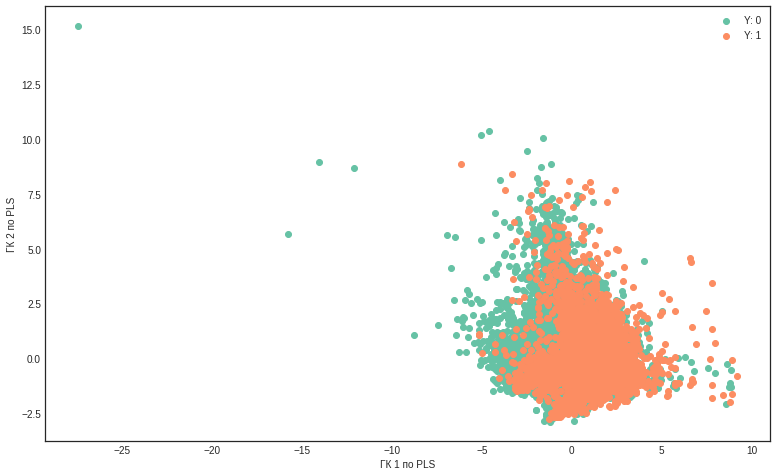

In [118]:
# график классов в пространстве ГК
plt.figure(figsize = (13,8))
plt.scatter(X_train_pls[DF_num['Y'] == 0][:, 0],
            X_train_pls[DF_num['Y'] == 0][:, 2], label='Y: 0')
plt.scatter(X_train_pls[DF_num['Y'] == 1][:, 0], 
            X_train_pls[DF_num['Y'] == 1][:, 2], label='Y: 1')

plt.xlabel('ГК 1 по PLS')
plt.ylabel('ГК 2 по PLS')
plt.legend()
plt.show()

Я провел много экспериментов с разным количеством главных компонент и попробовал построить срезы, чтобы найти когда классы можно будет визуально разделить. И наилучшие визуально результаты удалось добиться с количеством компонент 3 в двумерном пространстве 2 главных компонент первой и третьей.

In [119]:
# функция разбиения на блоки для перекрёстной проверки
#  для чистоты эксперимента возьмём другое ядро генератора случайных чисел
kf_10 = KFold(n_splits=10, random_state=my_seed+1, shuffle=True)
# считаем точность модели (Acc) с перекрёстной проверкой по блокам
#  функция cross_val_score не сработает, т.к. у нас мультиклассовая
#  классификация, поэтому делаем вручную
# значения Y как метки классов
Y_train = DF_num.Y.values
# значения Y как фиктивные переменные
Y_train_dummy = pd.get_dummies(Y_train.astype(str))
# модель внутри блока
pls_cv = PLSRegression(n_components=3)
# для записи Acc по блокам
acc_blocks = list()
# цикл по блокам
for train_index, test_index in kf_10.split(X_train_std, DF_num.Y.values) : 
    # данные для модели внутри блока
    X_i_train = X_train_std[train_index]
    Y_i_train = Y_train_dummy.iloc[train_index, :]

    # данные для прогноза вне блока
    X_i_test = X_train_std[test_index]
    Y_i_test = Y_train[test_index]

    # оцениваем модель на блоке
    pls_cv.fit(X_i_train, Y_i_train)
    # делаем прогноз y вне блока
    Y_pred = pls.predict(X_i_test)
    Y_hat = list()
    for y_i in Y_pred : 
        Y_hat.append([i for i in range(len(y_i)) if y_i[i] == max(y_i)][0])
    # считаем точность
    acc = accuracy_score(Y_i_test, Y_hat)
    acc_blocks.append(acc)
score=list()
score.append(np.around(np.mean(acc_blocks), 3))
score_models=list()
score_models.append('logit_PLS')
print('Модель ', score_models[0], ', перекрёстная проверка по 10 блокам',
      '\nAcc = ', np.around(score[0], 2), sep='')

Модель logit_PLS, перекрёстная проверка по 10 блокам
Acc = 0.8


## Лассо-регрессия

Технически реализация лассо-регрессии отличается от ридж единственным аргументом `penalty='l1'` в функции `LogisticRegression`.    

In [120]:
# функция для построения модели
logit_lasso = LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr')
# оцениваем параметры
logit_lasso.fit(X_train_std, Y_train)
# выводим параметры
print('Константы моделей для классов:\n', np.around(logit_lasso.intercept_, 3),
     '\nКоэффициенты моделей для классов:\n', np.around(logit_lasso.coef_, 3))

Константы моделей для классов:
 [-1.472] 
Коэффициенты моделей для классов:
 [[-0.102  0.047  0.677  0.193 -0.359  0.267 -0.193 -0.156 -0.048 -0.069
  -0.041 -0.036  0.062 -0.    -0.091  0.033  0.    -0.005 -0.051 -0.133
  -0.013 -0.059  0.08  -0.014  0.004]]


Метод лассо позволяет обнулять коэффициенты, тем самым отбрасывая слабые объясняющие переменные, и в данном случае мы видим что занулился вес при двух признаках.  

In [121]:
# поиск оптимального значения C:
#  подбираем C по наибольшей точности с перекрёстной проверкой
lasso_cv = LogisticRegressionCV(cv=10, random_state=my_seed+3,
                               penalty='l1', solver='liblinear')
lasso_cv.fit(X_train_std, Y_train)
# значения параметра C (инверсия лямбды), которые дают наилучшую
#  точность для каждого класса
lasso_cv.C_

array([0.35938137])

In [122]:
# сохраняем и выводим Acc для модели
score.append(np.around(lasso_cv.score(X_train_std, Y_train), 3))
score_models.append('logit_lasso')
print('Модель ', score_models[1], ', перекрёстная проверка по 10 блокам',
      '\nAcc = ', score[1], sep='')

Модель logit_lasso, перекрёстная проверка по 10 блокам
Acc = 0.811


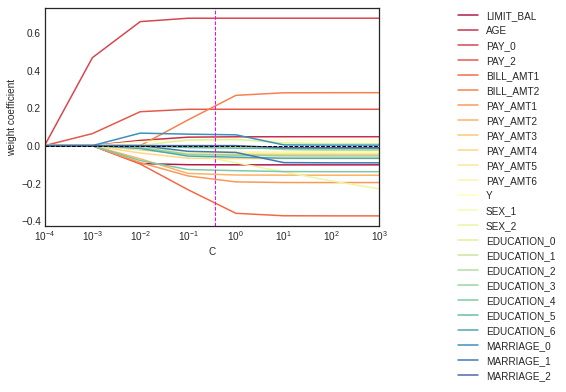

In [123]:
# график динамики коэффициентов в лассо-регрессии    
#  модель для класса 0
plot_coeffs_traces(X_train_std, Y_train, 0, 'l1', lasso_cv.C_, DF_num.columns)

Итак, судя по графикам, для значения гиперпараметра, дающего самую точную модель, некоторые коэффициенты при объясняющих переменных обнуляются. 
На этапе предварительного анализа мы заметили что один два признака плохо разделяют наши классы, что мы видим и здесь (коэффициенты при двух признаках близки к нулю). Все остальные объясняющие переменные неплохо разделяют классы.   


# Прогноз на отложенные наблюдения по лучшей модели

Ещё раз посмотрим на точность построенных моделей.  

In [124]:
# сводка по точности моделей
pd.DataFrame({'Модель' : score_models, 'Acc' : score})

,Модель,Acc
0,logit_PLS,0.800
1,logit_lasso,0.811


Все модели показывают высокую точность по показателю $Acc$, при этом самой точной оказывается Лассо-регрессия. Сделаем прогноз на отложенные наблюдения.   

In [125]:
# формируем объекты с данными отложенной выборки
X_pred_std = sc.fit_transform(DF_predict.drop('Y', axis=1).values)
Y_pred = DF_predict.Y
Y_hat = logit_lasso.predict(X_pred_std)
# отчёт по точности на отложенных наблюдениях
print(classification_report(Y_pred, Y_hat))

              precision    recall  f1-score   support

           0       0.82      0.97      0.89      3489
           1       0.72      0.24      0.36      1011

    accuracy                           0.81      4500
   macro avg       0.77      0.61      0.62      4500
weighted avg       0.79      0.81      0.77      4500



Итак, методом логистической регрессии со сжатием коэффициенты с L1
-регуляризацией мы получили идеально точную модель классификации ДВУХ КЛАССОВ данных.  

# Источники 

1. *Рашка С.* Python и машинное обучение: крайне необходимое пособие по новейшей предсказательной аналитике, обязательное для более глубокого понимания методологии машинного обучения / пер. с англ. А.В. Логунова. – М.: ДМК Пресс, 2017. – 418 с.: ил.  
1. Репозиторий с кодом к книге *Рашка С.* Python и машинное обучение / github.com. URL: <https://github.com/rasbt/python-machine-learning-book-3rd-edition>  
1. *Xueting Bai*, *Lingbo Wang*, *Hanning Li* Identification of red wine categories based on physicochemical properties / 2019 5th International Conference on Education Technology, Management and Humanities Science (ETMHS 2019). URL: <https://webofproceedings.org/proceedings_series/ESSP/ETMHS%202019/ETMHS19309.pdf>  

